In [1]:
import src
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

td = (
    src.preproc.load_data()
    .pipe(src.preproc.norm_and_shift_rates,norm_method='softnorm')
)
td

/Users/raeed/codebase/0-projects/human-m1-s1-analysis/src/preproc.py:191: RuntimeWarning: Mean of empty slice
  .agg(lambda s: np.nanmean(s,axis=0))


signal                                                            force  \
channel                                                              0    
set_trial trial_time             trial type force level state             
101       0 days 00:00:00        step       low         pretrial    0.0   
          0 days 00:00:00.020000 step       low         pretrial    0.0   
          0 days 00:00:00.040000 step       low         pretrial    0.0   
          0 days 00:00:00.060000 step       low         pretrial    0.0   
          0 days 00:00:00.080000 step       low         pretrial    0.0   
...                                                                 ...   
815       0 days 00:00:10.260000 step       medium      posttrial   0.0   
          0 days 00:00:10.280000 step       medium      posttrial   0.0   
          0 days 00:00:10.300000 step       medium      posttrial   0.0   
          0 days 00:00:10.320000 step       medium      posttrial   0.0   
          0 days 00:00:10.340000 step       medium      posttrial   0.0   

signal                                                                motor  \
channel                                                                  0    
set_trial trial_time             trial type force level state                 
101       0 days 00:00:00        step       low         pretrial  -0.148819   
          0 days 00:00:00.020000 step       low         pretrial  -0.132041   
          0 days 00:00:00.040000 step       low         pretrial  -0.113952   
          0 days 00:00:00.060000 step       low         pretrial  -0.095548   
          0 days 00:00:00.080000 step       low         pretrial  -0.077968   
...                                                                     ...   
815       0 days 00:00:10.260000 step       medium      posttrial -0.006589   
          0 days 00:00:10.280000 step       medium      posttrial -0.016167   
          0 days 00:00:10.300000 step       medium      posttrial -0.029348   
          0 days 00:00:10.320000 step       medium      posttrial -0.045766   
          0 days 00:00:10.340000 step       medium      posttrial -0.064776   

signal                                                                       \
channel                                                                  1    
set_trial trial_time             trial type force level state                 
101       0 days 00:00:00        step       low         pretrial  -0.237647   
          0 days 00:00:00.020000 step       low         pretrial  -0.206087   
          0 days 00:00:00.040000 step       low         pretrial  -0.173715   
          0 days 00:00:00.060000 step       low         pretrial  -0.141291   
          0 days 00:00:00.080000 step       low         pretrial  -0.109575   
...                                                                     ...   
815       0 days 00:00:10.260000 step       medium      posttrial -0.253927   
          0 days 00:00:10.280000 step       medium      posttrial -0.279706   
          0 days 00:00:10.300000 step       medium      posttrial -0.305269   
          0 days 00:00:10.320000 step       medium      posttrial -0.330206   
          0 days 00:00:10.340000 step       medium      posttrial -0.354035   

signal                                                                       \
channel                                                                  2    
set_trial trial_time             trial type force level state                 
101       0 days 00:00:00        step       low         pretrial  -0.131865   
          0 days 00:00:00.020000 step       low         pretrial  -0.122266   
          0 days 00:00:00.040000 step       low         pretrial  -0.110357   
          0 days 00:00:00.060000 step       low         pretrial  -0.096209   
          0 days 00:00:00.080000 step       low         pretrial  -0.080112   
...                                                                     ...   
815       0 days 00:00:1

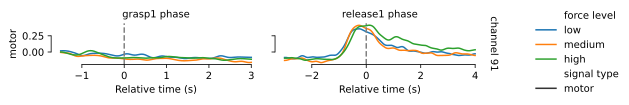

In [2]:
src.plot.plot_step_signal(td,'motor',[91],how_to_plot='average_only')

In [23]:
# z-scoring and softnorming seem to give very different results on PC space
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from src.models import DataFrameTransformer, ReducedRankRegression, VarimaxTransformer, NoMeanTransformPCA
import scipy.linalg as la

motor_pca = Pipeline(steps=[
    ('pca',DataFrameTransformer(NoMeanTransformPCA(n_components=15))),
    ('varimax',VarimaxTransformer())
])
sensory_pca = Pipeline(steps=[
    ('pca',DataFrameTransformer(NoMeanTransformPCA(n_components=15))),
    ('varimax',VarimaxTransformer())
])
rrr_model = ReducedRankRegression(rank=8,mean_in_transform=False,multioutput_score='variance_weighted')
rrr_varimax = VarimaxTransformer()
rrr_null_varimax = VarimaxTransformer()
td_step = (
    td
    .pipe(src.munge.get_step_grasp_release_data)
    .pipe(src.munge.group_average,keys=['force level','phase','relative time'])
    .dropna()
    .pipe(src.munge.hierarchical_assign,assign_dict={
        'motor pca': lambda df: motor_pca.fit_transform(df['motor']),
        'sensory pca': lambda df: sensory_pca.fit_transform(df['sensory']),
    })
    .pipe(src.munge.hierarchical_assign,assign_dict={
        'motor rrr': lambda df: (
            rrr_model
            .fit_transform(df['motor pca'],df['sensory pca'])
            .pipe(rrr_varimax.fit_transform)
        ),
    })
    .pipe(src.munge.hierarchical_assign,assign_dict={
        'motor rrr null': lambda df: (
            (df['motor pca'] @ la.null_space(rrr_model.encoder_.T))
            .pipe(rrr_null_varimax.fit_transform)
        ),
    })
    .pipe(src.munge.hierarchical_assign,assign_dict={
        'predicted sensory pca': lambda df: rrr_model.predict(df['motor pca']),
    })
)


In [22]:
null = la.null_space(rrr_model.encoder_.T)
full_basis=np.column_stack([null,rrr_model.encoder_])
np.allclose(full_basis.T @ full_basis,np.eye(15))

True

<Axes: >

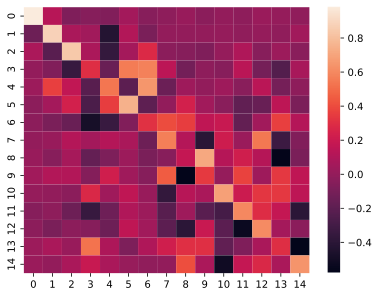

In [4]:
rot_mat = sensory_pca.get_params()['varimax'].rotation_matrix_
np.allclose(rot_mat @ rot_mat.T,np.eye(15))
sns.heatmap(rot_mat)

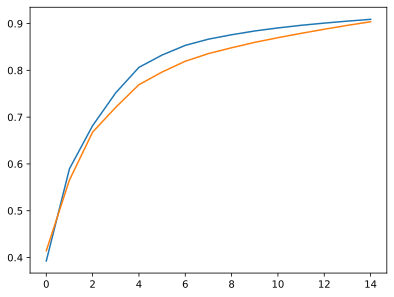

In [73]:
fig,ax = plt.subplots(1,1)
ax.plot(np.cumsum(motor_pca.transformer.explained_variance_ratio_))
ax.plot(np.cumsum(sensory_pca.transformer.explained_variance_ratio_))

In [9]:
rrr_model.score(td_step['motor pca'],td_step['sensory pca'])

0.8457326990036269

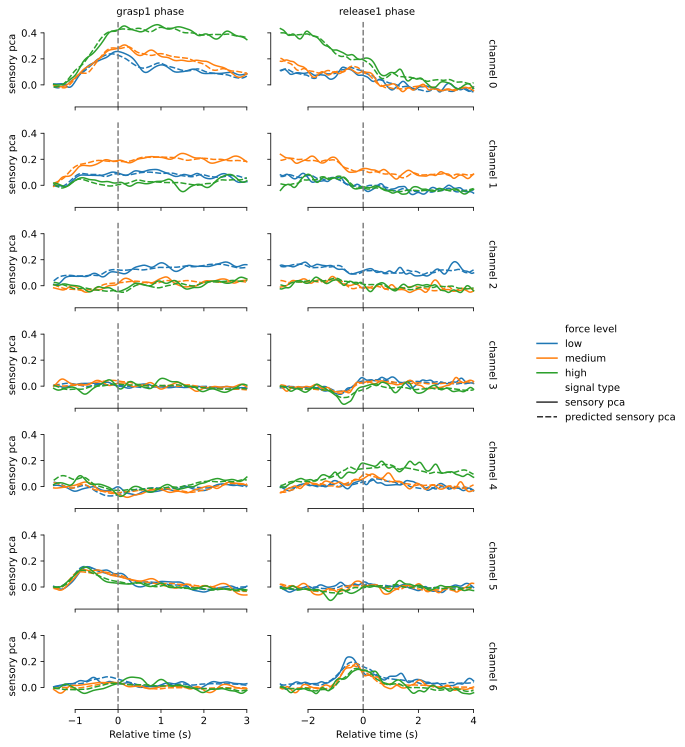

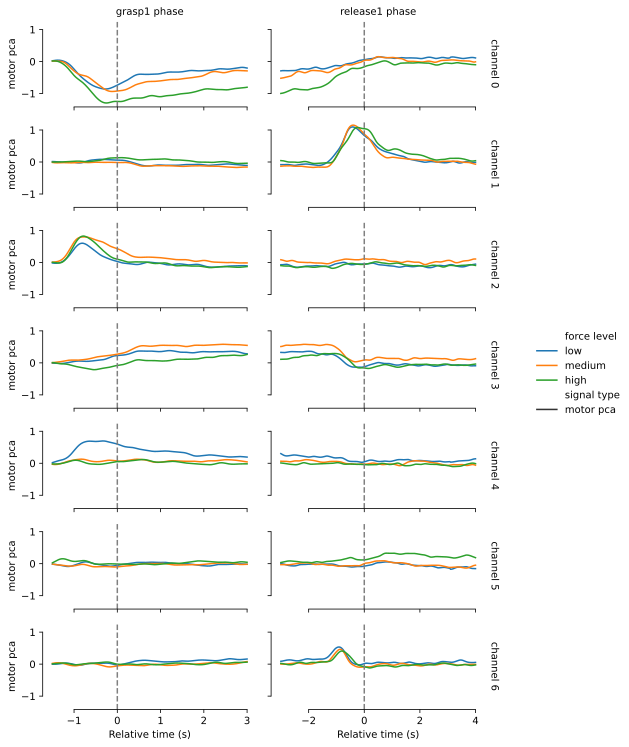

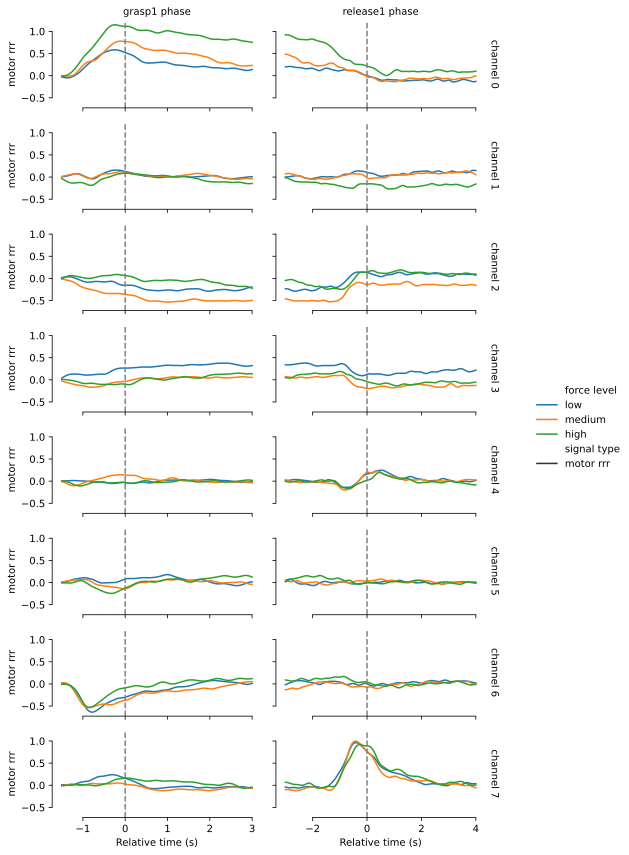

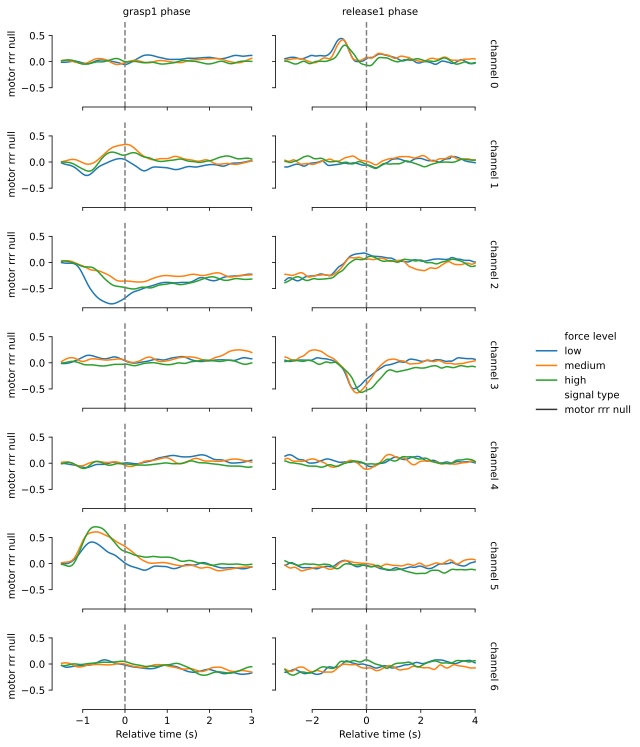

In [29]:
num_comps=7
g = src.plot.plot_step_signal(
    td_step,
    ['sensory pca','predicted sensory pca'],
    list(range(num_comps)),
    how_to_plot='average_only',
)
g = src.plot.plot_step_signal(
    td_step,
    'motor pca',
    list(range(num_comps)),
    how_to_plot='average_only'
)
g = src.plot.plot_step_signal(
    td_step,
    'motor rrr',
    list(range(8)),
    how_to_plot='average_only'
)
g = src.plot.plot_step_signal(
    td_step,
    'motor rrr null',
    list(range(7)),
    how_to_plot='average_only'
)

0.6343922824067113

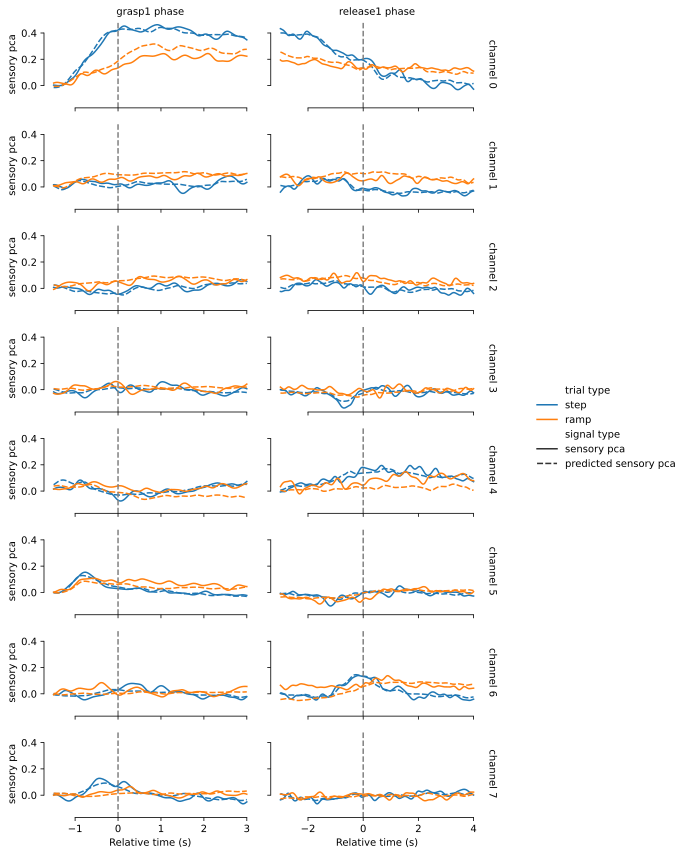

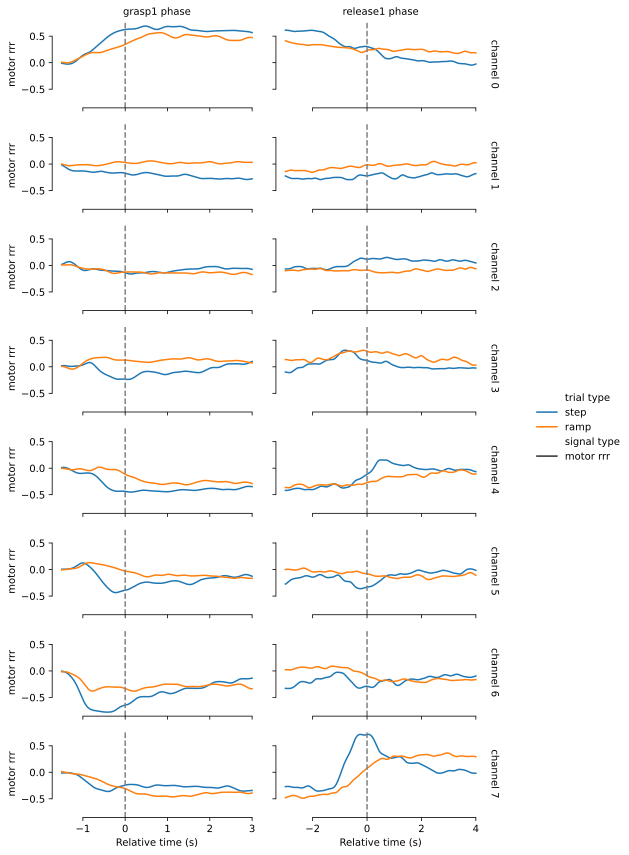

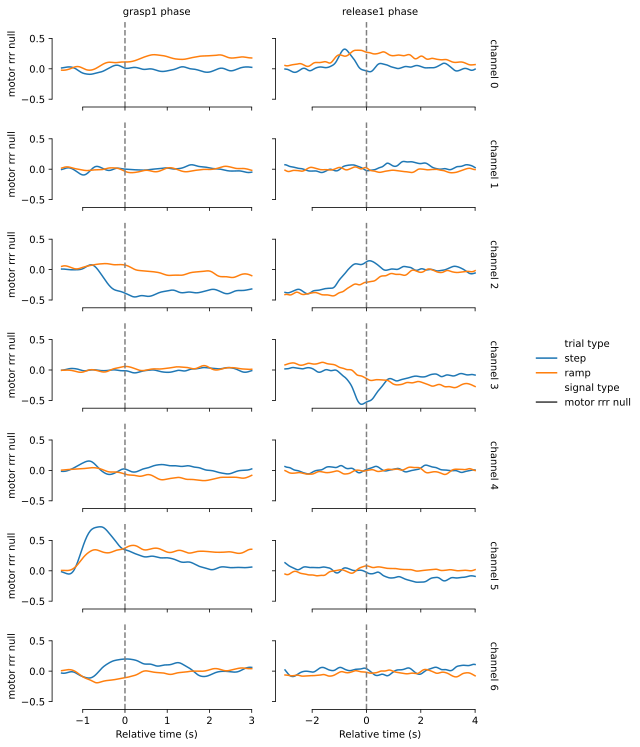

In [28]:
td_step_ramp = (
    td
    .groupby('force level',observed=True)
    .get_group('high')
    .pipe(src.munge.get_epoch_data,epochs={
        'grasp1': slice('-1500 ms','3000 ms'),
        'release1': slice('-3 sec','4 sec'),
    })
    .pipe(src.munge.group_average,keys=['trial type','phase','relative time'])
    .dropna()
    .pipe(src.munge.hierarchical_assign,assign_dict={
        'motor pca': lambda df: motor_pca.transform(df['motor']),
        'sensory pca': lambda df: sensory_pca.transform(df['sensory']),
    })
    .pipe(src.munge.hierarchical_assign,assign_dict={
        'motor rrr': lambda df: rrr_model.transform(df['motor pca']),
    })
    .pipe(src.munge.hierarchical_assign,assign_dict={
        'motor rrr null': lambda df: (
            (df['motor pca'] @ la.null_space(rrr_model.encoder_.T))
            .pipe(rrr_null_varimax.fit_transform)
        ),
    })
    .pipe(src.munge.hierarchical_assign,assign_dict={
        'predicted sensory pca': lambda df: rrr_model.predict(df['motor pca']),
    })
)

num_comps=8
g = src.plot.plot_trial_signal(
    td_step_ramp,
    ['sensory pca','predicted sensory pca'],
    list(range(num_comps)),
    hue='trial type',
    hue_order=['step','ramp'],
    how_to_plot='average_only',
)
g = src.plot.plot_trial_signal(
    td_step_ramp,
    ['motor rrr'],
    list(range(8)),
    hue='trial type',
    hue_order=['step','ramp'],
    how_to_plot='average_only',
)
g = src.plot.plot_trial_signal(
    td_step_ramp,
    ['motor rrr null'],
    list(range(7)),
    hue='trial type',
    hue_order=['step','ramp'],
    how_to_plot='average_only',
)
rrr_model.score(td_step_ramp['motor pca'],td_step_ramp['sensory pca'])

### Stuff that's in progress...

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA

rrr_pipeline = Pipeline([
    ('pca',src.models.DataFrameTransformer(PCA(n_components=15))),
    ('rrr',src.models.ReducedRankRegression(rank=5)),
])
sensory_pipeline = Pipeline([
    ('pca',PCA(n_components=15)),
])
regr = TransformedTargetRegressor(
    regressor=rrr_pipeline,
    transformer=sensory_pipeline,
)

step_data = (
    td
    .pipe(src.munge.get_step_grasp_release_data)
    .dropna()
)
# rrr_pipeline.fit_transform(step_data['motor'],step_data['sensory'])
# sensory_pipeline.fit_transform(step_data['sensory'])
regr.fit(step_data['motor'],step_data['sensory'])

/opt/homebrew/Caskroom/mambaforge/base/envs/human-m1-s1/lib/python3.11/site-packages/sklearn/compose/_target.py:190: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn(


TransformedTargetRegressor(regressor=Pipeline(steps=[('pca',
                                                      DataFrameTransformer(transformer=PCA(n_components=15))),
                                                     ('rrr',
                                                      ReducedRankRegression(rank=5))]),
                           transformer=Pipeline(steps=[('pca',
                                                        PCA(n_components=15))]))

In [47]:
(
    td.groupby('trial type')
    .get_group('ramp')
    .reset_index(level='force level')
    ['force level']
    .unique()
)
td.pipe(src.munge.group_average,keys=['trial type','force level','state'])

/var/folders/wf/m89rq9p97kq6fdqj23hkrm_h0000gn/T/ipykernel_43416/1517180176.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  td.groupby('trial type')


signal                                    force         motor                \
channel                                      0             0             1    
trial type  force level state                                                 
ramp        high        grasp1         9.300160  8.138255e-02  4.394741e-02   
                        grasp_prep     0.000000  4.180710e-02  1.852278e-02   
                        posttrial      0.000123  1.238987e-02  2.721837e-02   
                        pretrial       0.000000  4.916346e-18 -4.480721e-18   
                        release1       6.040027  4.938270e-02  5.190349e-02   
                        release_prep  13.976697  3.808122e-02 -1.497303e-03   
ramp+adjust double_ramp grasp1         3.460307  4.612879e-02  3.435524e-02   
                        grasp2        11.892571  4.737527e-02  1.016580e-02   
                        grasp_prep     0.000000  2.163474e-02  3.996100e-02   
                        posttrial     -0.000175  9.768046e-03  5.179068e-03   
                        pretrial       0.000000  2.192060e-18 -5.677277e-18   
                        release1      10.549367  5.366395e-02  5.062644e-02   
                        release2       3.558124  3.823024e-02  1.084842e-02   
                        release_prep  14.014570  3.756829e-02  2.473748e-02   
step        high        grasp1        13.908676  1.035401e-01  1.327984e-01   
                        grasp_prep     0.000000  8.546090e-02  1.360160e-01   
                        posttrial      0.000000  1.534799e-02  3.545456e-02   
                        pretrial       0.000000 -1.316870e-18 -2.836336e-18   
                        release1       0.242541  4.209498e-02  2.398021e-02   
                        release_prep  14.000000  3.548221e-02  2.300094e-03   
            low         grasp1         4.671249  3.552343e-02  9.999972e-02   
                        grasp_prep     0.000000  1.063531e-01  1.932974e-01   
                        posttrial      0.000000 -3.024423e-02 -3.249953e-02   
                        pretrial       0.000000 -3.120449e-18  7.062070e-18   
                        release1       0.085701 -2.997380e-03 -1.048037e-02   
                        release_prep   4.700000  2.081308e-02 -8.469380e-03   
            medium      grasp1         9.341918  4.899249e-02  4.039697e-02   
                        grasp_prep     0.000000  5.145462e-02  6.516790e-02   
                        posttrial      0.000000  7.685932e-03 -3.481370e-02   
                        pretrial       0.000000 -4.976862e-18  7.943837e-18   
                        release1       0.162692  2.847569e-02 -3.099034e-02   
                        release_prep   9.400000  2.331704e-02 -4.565226e-02   

signal                                                            \
channel                                         2             3    
trial type  force level state                                      
ramp        high        grasp1        7.319494e-02 -9.933889e-03   
                        grasp_prep    1.649060e-01 -2.833800e-02   
                        posttrial    -5.440381e-03 -5.314032e-02   
                        pretrial     -5.165275e-18  5.227508e-18   
                        release1      2.425723e-02 -4.903678e-02   
                        release_prep -3.731715e-02 -4.593087e-02   
ramp+adjust double_ramp grasp1        1.908888e-01  4.673628e-02   
                        grasp2        1.554171e-02  3.607262e-02   
                        grasp_prep    1.124468e-01  5.010653e-02   
                        posttrial    -1.418655e-02 -7.572088e-04   
                        pretrial     -3.721770e-18  5.551115e-18   
                        release1      5.381526e-02  6.989285e-03   
                        release2      1.351339e-01 -1.108400e-02   
                        release_prep -1.940529e-02  3.803478e-03   
step        high        grasp1       -6.147050e-03  1.407016e-01   
          

In [1]:
from sklearn.decomposition import _ortho_rotation

ImportError: cannot import name '_ortho_rotation' from 'sklearn.decomposition' (/opt/homebrew/Caskroom/mambaforge/base/envs/human-m1-s1/lib/python3.11/site-packages/sklearn/decomposition/__init__.py)

In [ ]:
step_ramp_data = (
    pd.concat([
        td_shifted.groupby('trial type').get_group(g)
        for g in ['step']
    ])
)
event_times = src.events.get_state_transition_times(step_ramp_data['state'])
grasp_times = event_times.loc[(slice(None),slice(None),'grasp1')]
release_times = event_times.loc[(slice(None),slice(None),'release1')]
hold_lens = release_times-grasp_times
sns.histplot(hold_lens.dt.total_seconds())